# Mathematical Language Text Understanding with Seq2Seq-Based Models

In this tutorial, we will be using a vanilla Seq2Seq model and a transformer Seq2Seq model to predict the definiton of a mathematical variable given a variable name and the context in which it is defined.

## The Vanilla Seq2Seq Model
The vanilla Seq2Seq model is the most basic Seq2Seq model. It generates an output sequence $(y = \{y_{1}, y_{2}, ..., y_{n}\})$ given an input sequence $(x = \{x_{1}, x_{2}, ..., x_{n}\})$ via the use of two recurrent neural networks (RNNs), an encoder and a decoder. The encoder RNN processes each $x_{i}$ and returns the final hidden state when it is finished. Using this final encoder hidden state, the decoder computes a hidden state for every possible definition token.  These hidden states are used to find the most likely token for that definition position via a probability distubution over all input words in the training data. The figure below illustrates the encoder-decoder process.

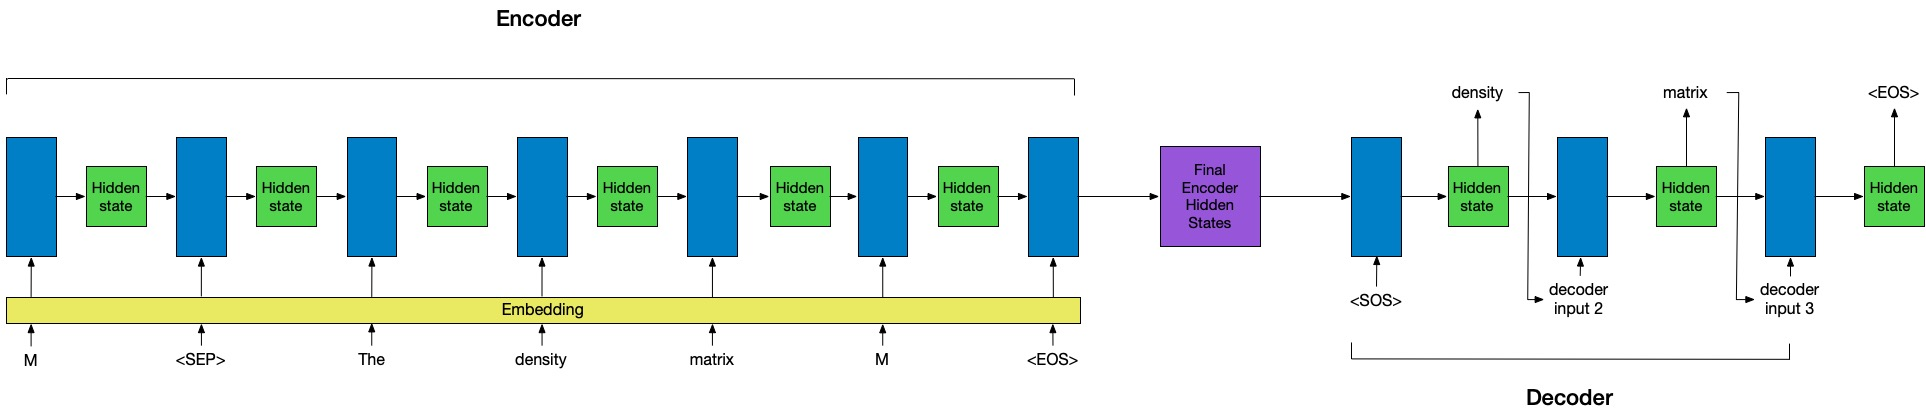

To find the best output sequence, generative models use the probability chain rule, which states that the probability of an sequence is the conditional probability of its individual tokens.  We represent this in the following relation, where $T$ is the training data and $\theta$ is the parameters of the RNN:
\begin{align}
p_{\theta}(y|T; \theta) = \prod^{i}{p_{\theta}(y_{i}| y_{i-1}, y_{i-2}, ... y_{1}, T;\theta)}
\end{align}

This framework computes the parameters for the paramedic model (I.E the encoder RNN and decoder RNN for a seq2seq model) by finding the maximum conditional probability over all tokens in the training data.

## The Transformer Seq2Seq Model

Vanilla Seq2Seq models wholly rely on the encoder hidden state to pass on the important parts of the input sequence to the decoder. Attention-based methods add another layer of information retention to the model via a context vector. This vector maps pertinent information from the input sequence to the output sequence, allowing the model to "focus" on the useful parts of the sentence. For our model, we used Bahdanau Attention with the decoder RNN (see: https://arxiv.org/pdf/1409.0473.pdf). Attention is calculates by first calculating an annotation for each input word is generated based on the word itself and its surrounding words. After this, these encoder annotations are combined with the $i$-th decoder hidden state to "score"
how likely the $j$-th input word is related to the $i$-th output word. This score is calculated as such:

between the $j$-th encoder hidden state $h_{j}$ and the :

\begin{align}
\alpha_{ij} = \frac{exp(a(s_{i - 1}, h_{j}))}{\Sigma^{T_{x}}_{k=1}{exp(a(s_{i - 1}, h_{j}))}} = softmax(a(s_{i - 1}, h_{j}))
\end{align}

where $h_{j}$ is the the $j$-th encoder hidden state, $s_{i - 1}$ is the $i - 1$-th decoder hidden state, and $a(s_{i - 1}, h_{j})$ is the alignment function which ranks how likely an input word is related to an output word. For this tutorial, we use "additive" attention:

\begin{align}
a(s_{i - 1}, h_{j}) = v^{\intercal}tanh(W_{1}s_{i - 1} + W_{2}h_{j})
\end{align}

Once the attention scores are calcuated, we can find the context vector. The context vector is simply the weighted sum of encoder hidden states with the attention scores as the weights:

as a weighted sum of the annotation $h_{j}$:
\begin{align}
c_{i} = \Sigma^{k}_{j=1}{\alpha_{ij}h_{j}}
\end{align}
where $i$ is the indicates the length of the output sequence and $k$ is the length of the input sequence.

![Transformer Model](images/attention_figure.jpg)

In both models, we used Long Short-Term Memory RNNs for all of the models. This RNN cell architecture has a "forget gate" that selectively zeros-out parts of the sequence that are not important. This makes it favorable for language generative tasks as it is better able to retain critical information. 

## Let's get started!
To start, let's define a Pytorch Dataset. This is a data object will take our data and prepare it to be fed into a model. This entails cleaning the data, tokenizing it, and partitioning it into batchs. I highly recommend the use of the pytorch dataset object in any pytorch project you may do because of its compatability with the pytorch dataloader. The dataloader will batch and randomize your data for you, making it easy to train your model.

## The Data and How We Process It
The data used in this tutorial is sourced from mathematical and physics papers from arXiv and manually cleaned. For each entry in the dataset, we are given a variable name, the context in which it is defined, and an definition of the variable. The model should process the variable name and the context and should be able to output the definiton. However, Seq2Seq models are not generally equipt to handle two input variables. Thus, inspired by BERT models, we opted to combined the two inputs into one with a \<SEP\> token. This can be seen the both pictures above. 

Additionally, we add an \<EOS\> token to the end of all inputs and outputs. However, we one use the \<SOS\> token to begin the decoding.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import random
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import math
import numpy as np

In [ ]:
class Seq2SeqModelDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        # The tokenized inputs and outputs
        self.texts = []
        self.outputs = []
        
        # Maps each index to a unique word and vice versa
        self.word2index = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "SEP"}
        
        self.sos = 1
        self.eos = 2
        self.sep = 3
        
        self.text_max_len = 0
        self.def_max_len = 0
        self.size = len(self.index2word)
        
        # Process the data
        self.prep_data()

    def add_text(self, text):
        """Assigns a unique index to each word in a sentence

        Args:
          text: A sentence
        """
        for word in text.split(' '):
            if word not in self.word2index:
                self.word2index[word] = self.size
                self.index2word[self.size] = word
                self.size += 1

    def clean_text(self, text):
        """Strips text of any punctuation, converts to lower case, and gets rid of any 
        unnecessary white space.

        Args:
          text: the uncleaned sentence.

        Returns:
          The cleaned sentence.
        """
        text = text.replace('"', '').lower().strip()
        text = text.replace(",", "").replace(".", "").replace("!", "").replace("?", "").replace("(", "").replace(")", "").replace(":", "").replace("|", " ").replace("  ", " ").strip().replace(";", "")
        text = text.split(" ")
        text = ' '.join(text)
        return text

    def prep_data(self):
        """The main function of the dataset object.
        This function cleans and tokenizes each entry, as well as set the maximum text and definition length. 
        """
        text_max_len = 0
        def_max_len = 0
        for index, row in self.df.iterrows():
            var = self.clean_text(row["var"])
            context = self.clean_text(row["context"])
            definition = self.clean_text(row["def"])
            
            # Assign unique tokens for each word in the context and definition
            self.add_text(context)
            
            # Add definition seperately because sometimes the definition is the singular version of a word in the context
            self.add_text(definition)

            # Tokenize input and outputs texts
            # For the seq2seq models, we use a 'bert-like' input text that combines the two input sequences with a <SEP> token
            input_text = [self.word2index[var]] + [self.sep] + [self.word2index[c] for c in context.split(" ")] + [self.eos]
            output_text = [self.word2index[c] for c in definition.split(" ")] + [self.eos]
            
            self.texts.append(input_text)
            self.outputs.append(output_text)
            
            if len(input_text) > text_max_len:
                text_max_len = len(input_text)

            if len(output_text) > def_max_len:
                def_max_len = len(output_text)
                
        # Set the maximum text and definiton length
        # This is important when defining the models
        self.text_max_len = text_max_len
        self.def_max_len = def_max_len

    def collate_fn(self, batch):
        """This function is used by the dataloader to create batchs. 
        It seperated the inputs and the outputs and then pads them.

        Args:
          batch: A list of data entries of size batch_size.

        Returns:
          The padded inputs and outputs.
        """
        texts = [torch.LongTensor(b[0]) for b in batch]
        defs = [torch.LongTensor(b[1]) for b in batch]
        return (pad_sequence(texts), pad_sequence(defs))

    def __len__(self):
        """This is a required function.
        It returns the size of the dataset.
        
        Returns:
          The size of the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """This is a required function.
        It returns the data entry at index at idx.
        
        Args:
          idx: An index.
          
        Returns:
          The data entry at index idx.
        """
        return (self.texts[idx], self.outputs[idx])


## Implementing the Vanilla Seq2Seq Model

In [ ]:
class Seq2SeqVanilla(nn.Module):
    """This implementation was inspired by: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    """
    def __init__(self, learning_rate, size, hidden_size, optimizer, batch_size, answer_max_len, context_max_len):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embed = nn.Embedding(size, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size)
        self.decoder = VanillaDecoder(hidden_size, size, batch_size)
        self.answer_max_len = answer_max_len
        self.context_max_len = context_max_len
        self.batch_size = batch_size
        self.size = size

        if optimizer == "sgd":
            self.encoder_opt = optim.SGD(self.encoder.parameters(), lr=learning_rate)
            self.decoder_opt = optim.SGD(self.decoder.parameters(), lr=learning_rate)
        else:
            self.encoder_opt = optim.Adam(self.encoder.parameters(), lr=learning_rate)
            self.decoder_opt = optim.Adam(self.decoder.parameters(), lr=learning_rate)

    def forward(self, input_tensor):
        # Calculate encoder hidden states
        embed = self.embed(input_tensor)
        encoder_output, encoder_hidden = self.encoder(embed)

        # Make sure 1 corrosponds with the <SOS> token in the dataset!
        decoder_input = torch.tensor([1] * self.batch_size, device=self.device)
        outputs = torch.zeros(self.answer_max_len, self.batch_size, device=self.device)
        decoder_hidden = encoder_hidden

        # Calculate and store all decoder outputs
        for di in range(self.answer_max_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            output_token = decoder_output.argmax(1)
            outputs[di] = output_token
            decoder_input = output_token

        return outputs

    def train(self, training_dataloader, epochs, teacher_forcing_ratio=0.5):
        for e in range(epochs):
            total_loss = 0
            
            # input_tensor: (input_length, batch_size), target_tensor: (target_length, batch_size)
            for input_tensor, target_tensor in training_dataloader:
                self.encoder_opt.zero_grad()
                self.decoder_opt.zero_grad()
                
                loss = 0
                target_length = target_tensor.shape[0]

                # Calculate encoder hidden state
                embed = self.embed(input_tensor)
                encoder_output, encoder_hidden = self.encoder(embed)

                # Make sure 1 corrosponds with the <SOS> token in the dataset!
                decoder_input = torch.tensor([1] * self.batch_size, device=self.device)
                outputs = torch.zeros(self.answer_max_len, self.batch_size, self.size, device=self.device)
                decoder_hidden = encoder_hidden

                # Teacher forcing trains a model by feeding the target tokens into the decoder instead of the previous decoder outputs
                use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

                # Calculate and store all decoder outputs
                for di in range(target_length):
                    decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                    outputs[di] = decoder_output
                    loss += F.nll_loss(decoder_output, target_tensor[di])
                    if use_teacher_forcing:
                        decoder_input = target_tensor[di]
                    else:
                        decoder_input = decoder_output.argmax(1)

                loss.backward()

                self.encoder_opt.step()
                self.decoder_opt.step()
                total_loss += loss.item()

            # Print loss every other epoch
            if e % 2 == 0:
                print("epoch", e, np.round(total_loss / len(training_dataloader), 3))

    def evaluate(self, dataloader):
        correct = 0
        precision = 0
        recall = 0

        # input_tensor: (input_length, batch_size), target_tensor: (target_length, batch_size)
        for input_tensor, target_tensor in dataloader:
            with torch.no_grad():
                outputs = self.forward(input_tensor)
                
                # permute so every tensor is one output
                outputs = outputs.permute((1, 0)).type(torch.LongTensor)
                target_tensor = target_tensor.permute((1, 0)).type(torch.LongTensor)
                
                # We remove all padding and <EOS> tokens as these are usually pretty easy for an NN to learn
                # This also allows us to compare target_tensors that are shorter than def_max_len
                outputs = outputs.numpy()
                target_tensor = target_tensor.numpy()
                
                outputs = [output[output != 2] for output in outputs] # remove <EOS>
                target_tensor = [target[target != 2] for target in target_tensor] # remove <EOS>
                outputs = [output[output != 0] for output in outputs] # remove padding
                target_tensor = [target[target != 0] for target in target_tensor] # remove padding
                
                # Count the number of completely correct outputs
                correct += sum([1 for i, j in zip(outputs, target_tensor) if (i == j).all()])
                
                precision += sum([len(np.intersect1d(i, j)) / len(i) for i, j in zip(outputs, target_tensor)])
                recall += sum([len(np.intersect1d(i, j)) / len(j) for i, j in zip(outputs, target_tensor)])
                
        data_size = (dataloader.batch_size * len(dataloader))
        
        # Get average precision and recall score
        precision /= data_size
        recall /= data_size
        
        F1_score = (2 * precision * recall) / (precision + recall)
        data_size = (dataloader.batch_size * len(dataloader))
        return np.round(correct / data_size, 3), np.round(F1_score, 3)

class VanillaDecoder(nn.Module):
    """ This class is the Decoder RNN. It generates an output sequence based on the hidden state of the Encoder."""
    def __init__(self, hidden_size, output_size, batch_size):
        super(VanillaDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.embed = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embed(input.unsqueeze(0)) # (1, batch_size, hidden_size)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = self.softmax(self.out(output.squeeze(0))) # (batch_size, hidden_size)
        return output, hidden

## Implementing the Transformer Seq2Seq Model

In [ ]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, learning_rate, size, hidden_size, optimizer, batch_size, answer_max_len, context_max_len):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embed = nn.Embedding(size, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size)
        self.decoder = TransformerDecoder(hidden_size, size, batch_size, context_max_len)
        self.answer_max_len = answer_max_len        
        self.context_max_len = context_max_len
        self.batch_size = batch_size
        self.size = size

        if optimizer == "sgd":
            self.encoder_opt = optim.SGD(self.encoder.parameters(), lr=learning_rate)
            self.decoder_opt = optim.SGD(self.decoder.parameters(), lr=learning_rate)
        else:
            self.encoder_opt = optim.Adam(self.encoder.parameters(), lr=learning_rate)
            self.decoder_opt = optim.Adam(self.decoder.parameters(), lr=learning_rate)

    def forward(self, input_tensor):
        # Calculate and store all encoder outputs for each word in the input sentence
        embed = self.embed(input_tensor)
        encoder_outputs, encoder_hidden = self.encoder(embed)

        # Make sure 1 corrosponds with the <SOS> token in the dataset!
        decoder_input = torch.tensor([1] * self.batch_size, device=self.device)
        outputs = torch.zeros(self.answer_max_len, self.batch_size, device=self.device)
        decoder_hidden = encoder_hidden

        # Calculate and store all decoder outputs
        for di in range(self.answer_max_len):
            decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            output_token = decoder_output.argmax(1)
            outputs[di] = output_token
            decoder_input = output_token

        return outputs

    def train(self, training_dataloader, epochs, teacher_forcing_ratio=0.5):
        for e in range(epochs):
            total_loss = 0
            # input_tensor: (input_length, batch_size), target_tensor: (target_length, batch_size)
            for input_tensor, target_tensor in training_dataloader: 
                self.encoder_opt.zero_grad()
                self.decoder_opt.zero_grad()
                
                loss = 0
                input_length = input_tensor.shape[0]
                target_length = target_tensor.shape[0]
                
                # Calculate and store all encoder outputs for each word in the input sentence
                embed = self.embed(input_tensor)
                encoder_outputs, encoder_hidden = self.encoder(embed)


                # Make sure 1 corrosponds with the <SOS> token in the dataset!
                decoder_input = torch.tensor([1] * self.batch_size, device=self.device)
                outputs = torch.zeros(self.answer_max_len, self.batch_size, self.size, device=self.device)
                decoder_hidden = encoder_hidden

                # Teacher forcing trains a model by feeding the target tokens into the decoder instead of the previous decoder outputs
                use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

                # Calculate and store all decoder outputs
                for di in range(target_length):
                    decoder_output, decoder_hidden, decoder_attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                    outputs[di] = decoder_output
                    loss += F.nll_loss(decoder_output, target_tensor[di])
                    if use_teacher_forcing:
                        decoder_input = target_tensor[di]
                    else:
                        decoder_input = decoder_output.argmax(1)

                loss.backward()

                self.encoder_opt.step()
                self.decoder_opt.step()
                total_loss += loss.item()

            # Print loss every other epoch
            if e % 2 == 0:
                print("epoch", e, np.round(total_loss / len(training_dataloader), 3))

    def evaluate(self, dataloader):
        correct = 0
        precision = 0
        recall = 0

        # input_tensor: (input_length, batch_size), target_tensor: (target_length, batch_size)
        for input_tensor, target_tensor in dataloader:
            with torch.no_grad():
                outputs = self.forward(input_tensor)
                
                # permute so every tensor is one output
                outputs = outputs.permute((1, 0)).type(torch.LongTensor)
                target_tensor = target_tensor.permute((1, 0)).type(torch.LongTensor)
                
                # We remove all padding and <EOS> tokens as these are usually pretty easy for an NN to learn
                # This also allows us to compare target_tensors that are shorter than def_max_len
                outputs = outputs.numpy()
                target_tensor = target_tensor.numpy()
                
                outputs = [output[output != 2] for output in outputs] # remove <EOS>
                target_tensor = [target[target != 2] for target in target_tensor] # remove <EOS>
                outputs = [output[output != 0] for output in outputs] # remove padding
                target_tensor = [target[target != 0] for target in target_tensor] # remove padding

                # Count the number of completely correct outputs
                correct += sum([1 for i, j in zip(outputs, target_tensor) if (i == j).all()])
                
                precision += sum([len(np.intersect1d(i, j)) / len(i) for i, j in zip(outputs, target_tensor)])
                recall += sum([len(np.intersect1d(i, j)) / len(j) for i, j in zip(outputs, target_tensor)])
                
        data_size = (dataloader.batch_size * len(dataloader))
        
        # Get average precision and recall score
        precision /= data_size
        recall /= data_size
        
        F1_score = (2 * precision * recall) / (precision + recall)
        data_size = (dataloader.batch_size * len(dataloader))
        return np.round(correct / data_size, 3), np.round(F1_score, 3)

class TransformerDecoder(nn.Module):
    """ This class is the Decoder RNN. It generates an output sequence based on the hidden state of the Encoder."""
    def __init__(self, hidden_size, output_size, batch_size, max_len, dropout_p=0.1):
        super(TransformerDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.batch_size = batch_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.W1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.v = nn.Linear(self.hidden_size, 1)

        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input)) # (batch_size, hidden_size)

        # Use additive attention to compute scores
        scores = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden[0]))) # (context_max_len, batch_size, 1)
        attn_weights = F.softmax(scores, dim=0)
        
        # Permute these values for bmm (batch matrix multiplication)
        attn_weights = attn_weights.permute((1, 2, 0))
        encoder_outputs = encoder_outputs.permute((1, 0, 2))
        
        context_vector = torch.bmm(attn_weights, encoder_outputs).squeeze(1) # (batch_size, hidden_size)
        combine = self.attn_combine(torch.cat((embedded, context_vector), 1)).unsqueeze(0) # (1, batch_size, hidden_size)
        output, hidden = self.lstm(combine, hidden)
        output = F.log_softmax(self.out(output.squeeze(0)), dim=1) # (batch_size, size)
        return output, hidden, attn_weights

## Putting It All Together
Now that we have all the important parts implemented, let's train and evaluate the models!

In [ ]:
data = pd.read_csv("data.csv")

# Randomize the dataframe
data = data.sample(frac=1).reset_index(drop=True)

dataset = Seq2SeqModelDataset(data)

# we use a 80/20 split to partition the data into training and testing data
i = math.floor(0.8 * len(data))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [i, len(data) - i])

In [ ]:
# Play around with these parameters!!!
lr = 0.1
epochs = 40
optimizer = 'sgd' # could also be 'adam'
batch_size = 32
hidden_size = 256

# Dataloaders are awesome: they randomize and batch your data for you!
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=dataset.collate_fn, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=dataset.collate_fn, drop_last=True)

# Train vanilla model
vanilla_model = Seq2SeqVanilla(lr, dataset.size, hidden_size, optimizer, batch_size, dataset.def_max_len, dataset.text_max_len)
print("Training Vanilla Model")
vanilla_model.train(train_dataloader, epochs)

# Train transformer model
transformer_model = Seq2SeqTransformer(lr, dataset.size, hidden_size, optimizer, batch_size, dataset.def_max_len, dataset.text_max_len)
print("Training Transformer Model")
transformer_model.train(train_dataloader, epochs)

# Evaulate vanilla model 
vanilla_train_totally_correct, vanilla_train_partially_correct = vanilla_model.evaluate(train_dataloader)
print("VANILLA PERFORMANCE ON TRAINING DATA", "completely correct", vanilla_train_totally_correct, "F1 score", vanilla_train_partially_correct)
vanilla_test_totally_correct, vanilla_test_partially_correct = vanilla_model.evaluate(test_dataloader)
print("VANILLA PERFORMANCE ON TESTING DATA", "completely correct", vanilla_test_totally_correct, "F1 score", vanilla_test_partially_correct)

# Evaluate transformer model
transformer_train_totally_correct, transformer_train_partially_correct = transformer_model.evaluate(train_dataloader)
print("TRANSFORMER PERFORMANCE ON TRAINING DATA", "completely correct", transformer_train_totally_correct, "F1 score", transformer_train_partially_correct)
transformer_test_totally_correct, transformer_test_partially_correct = transformer_model.evaluate(test_dataloader)
print("TRANSFORMER PERFORMANCE ON TESTING DATA", "completely correct", transformer_test_totally_correct, "F1 score", transformer_test_partially_correct)